In [1]:
import functools
import numpy as np
import scipy
import sympy
import matplotlib.pyplot as plt
import keras
import keras.backend as K
sympy.init_printing()

Using TensorFlow backend.


In [2]:
x = [sympy.Symbol(f'x_{i}', real=True) for i in range(4)]
F = sum([sympy.sin(x_*(np.random.rand()-0.5)) for x_ in x])
iF = [F.integrate(x_) for x_ in x]
lambda_F = sympy.lambdify(tuple(x), F)
lambda_iF = [sympy.lambdify(tuple(x), iF_, modules=['numpy', {'erf': scipy.special.erf}]) for iF_ in iF]

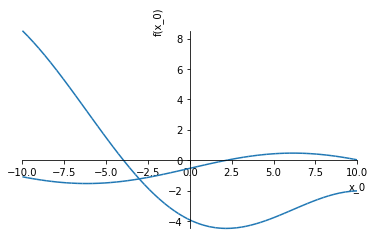

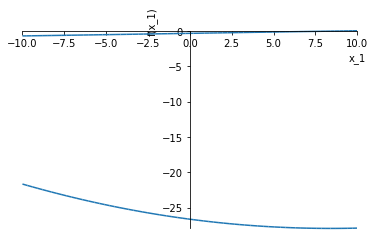

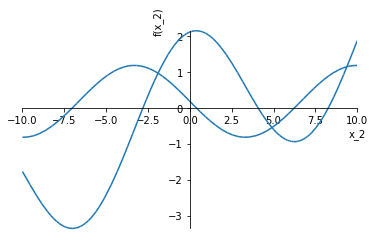

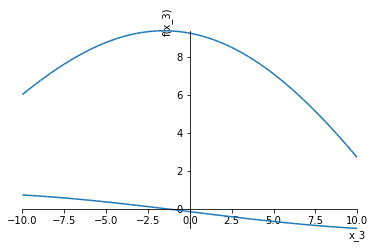

In [3]:
for x_,iF_ in zip(x,iF):
    sympy.plot(
        F.subs({x__:1 for x__ in x if x__ is not x_}),
        iF_.subs({x__:1 for x__ in x if x__ is not x_}))

In [4]:
xtrain = (np.random.random((100000,len(x))) - 0.5) * 20
xtest = (np.random.random((30,len(x))) - 0.5) * 20
ytrain, ytest = lambda_F(*np.hsplit(xtrain,len(x))), lambda_F(*np.hsplit(xtest,len(x)))

In [77]:
class MergeOutput(keras.layers.Layer):
    
    def __init__(self, diverge_penalty=1., ** kwargs):
        self.diverge_penalty = diverge_penalty
        super(MergeOutput, self).__init__(**kwargs)
    
    def build(self, input_shape):
        super(MergeOutput, self).build(input_shape)
    
    def call(self, inputs):
        output_divergence = K.var(inputs, axis=-1)
        output_divergence = K.sum(output_divergence) * self.diverge_penalty
        self.add_loss(output_divergence, inputs=inputs)
        return K.mean(inputs, axis=-1, keepdims=False)
    
    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

In [78]:
def build_nn_pair(n_input, n_output):
    X = X_input = keras.layers.Input((n_input,))
    X = keras.layers.BatchNormalization()(X)
    for _ in range(3):
        X_skip = X
        X = keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal')(X)
        X = keras.layers.Dense(128)(X)
        X = keras.layers.Concatenate()([X, X_skip])
        X = keras.layers.Activation('tanh')(X)
    X = keras.layers.Dense(n_input * n_output)(X)
    X = keras.layers.Reshape((n_output, n_input))(X)
    M_Integral = keras.Model(X_input, X)
    M_Integral.compile(keras.optimizers.SGD(momentum=0.9), 'mse', ['mae'])
    X = M_Integral(X_input)
    def compute_grads(x, n_input, n_output):
        grads = [
            K.gradients(x[1][:,j,i], x[0])[0][:,i:i+1]
            for j in range(n_output)
            for i in range(n_input)]
        grads = K.concatenate(grads)
        grads = K.reshape(grads, (-1, n_output, n_input))
        return grads
    X = keras.layers.Lambda(
        lambda x, n_input, n_output: compute_grads(x, n_input, n_output) + K.sum(x[1])*0,
        output_shape=(n_output, n_input),
        arguments={'n_input': n_input, 'n_output': n_output})([X_input, X])
    X = MergeOutput(diverge_penalty=0.01)(X)
    M_DIntegral = keras.Model(X_input, X)
    M_DIntegral.compile(keras.optimizers.SGD(momentum=0.9), 'mse', ['mae'])
    return M_Integral, M_DIntegral

In [79]:
M_Integral, M_DIntegral = build_nn_pair(len(x),1)
M = M_DIntegral
M.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 4)            0                                            
__________________________________________________________________________________________________
model_23 (Model)                (None, 1, 4)         102180      input_12[0][0]                   
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, 1, 4)         0           input_12[0][0]                   
                                                                 model_23[1][0]                   
__________________________________________________________________________________________________
merge_output_8 (MergeOutput)    (None, 1)            0           lambda_12[0][0]                  
Total para

In [81]:
M.fit(xtrain, ytrain, validation_data=(xtest, ytest), batch_size=256, epochs=150, callbacks=[
    keras.callbacks.LearningRateScheduler(
        lambda epoch,lr: 1e-5)#(np.cos(np.log(epoch+1) * 2*np.pi)+1)/2 * 1, verbose=1),
])

Train on 100000 samples, validate on 30 samples
Epoch 1/150
100000/100000 [==============================] - 7s 66us/step - loss: 0.5411 - mean_absolute_error: 0.4214 - val_loss: 0.2822 - val_mean_absolute_error: 0.3729
Epoch 2/150
100000/100000 [==============================] - 7s 73us/step - loss: 0.5008 - mean_absolute_error: 0.4056 - val_loss: 0.3040 - val_mean_absolute_error: 0.3999
Epoch 3/150
100000/100000 [==============================] - 6s 63us/step - loss: 0.4803 - mean_absolute_error: 0.3989 - val_loss: 0.2962 - val_mean_absolute_error: 0.4008
Epoch 4/150
100000/100000 [==============================] - 6s 61us/step - loss: 0.4719 - mean_absolute_error: 0.3960 - val_loss: 0.2979 - val_mean_absolute_error: 0.4041
Epoch 5/150
100000/100000 [==============================] - 6s 63us/step - loss: 0.4640 - mean_absolute_error: 0.3924 - val_loss: 0.3083 - val_mean_absolute_error: 0.4140
Epoch 6/150
100000/100000 [==============================] - 6s 62us/step - loss: 0.4628 - m

100000/100000 [==============================] - 6s 62us/step - loss: 0.4621 - mean_absolute_error: 0.3925 - val_loss: 0.3080 - val_mean_absolute_error: 0.4196
Epoch 49/150
100000/100000 [==============================] - 6s 62us/step - loss: 0.4599 - mean_absolute_error: 0.3911 - val_loss: 0.3059 - val_mean_absolute_error: 0.4186
Epoch 50/150
100000/100000 [==============================] - 6s 62us/step - loss: 0.4603 - mean_absolute_error: 0.3906 - val_loss: 0.3121 - val_mean_absolute_error: 0.4250
Epoch 51/150
100000/100000 [==============================] - 6s 62us/step - loss: 0.4602 - mean_absolute_error: 0.3910 - val_loss: 0.3164 - val_mean_absolute_error: 0.4241
Epoch 52/150
100000/100000 [==============================] - 6s 62us/step - loss: 0.4593 - mean_absolute_error: 0.3896 - val_loss: 0.3112 - val_mean_absolute_error: 0.4196
Epoch 53/150
100000/100000 [==============================] - 6s 62us/step - loss: 0.4610 - mean_absolute_error: 0.3915 - val_loss: 0.3106 - val_mea

KeyboardInterrupt: 

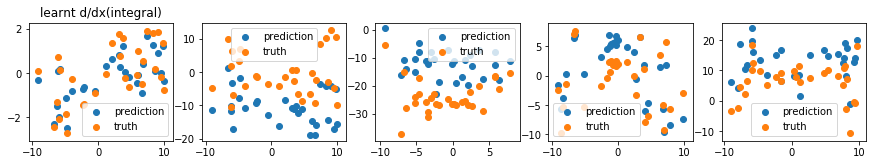

In [82]:
plt.figure(figsize=(15,10))
plt.subplot(4,5,1)
plt.title('learnt d/dx(integral)')
plt.scatter(xtest[:,0], M_DIntegral.predict(xtest), label='prediction')
plt.scatter(xtest[:,0], lambda_F(*np.hsplit(xtest, len(x))), label='truth')
plt.legend()
integrals = M_Integral.predict(xtest)
for i in range(len(x)):
    D = (i+1)
    plt.subplot(4,5,i+2)
    #plt.title(f'integrate from x-{D} to x+{D}')
    plt.scatter(xtest[:,i],
                integrals[:,0,i],
                label='prediction')
    plt.scatter(xtest[:,i],
                lambda_iF[i](*np.hsplit(xtest, len(x))),
                label='truth')
    plt.legend()
plt.show()